In [1]:
from SBM_SDE import *
from obs_and_flow import *
from get_CO2 import *
import torch
from torch import nn
import torch.distributions as d
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
from tqdm.notebook import tqdm
import random
from torch.autograd import Function
import argparse
import os
import sys
from pathlib import Path
import shutil
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
torch.manual_seed(0)
devi = torch.device("".join(["cuda:",f'{cuda_id}']) if torch.cuda.is_available() else "cpu")

cuda_id = 1
dt = 0.2 #SDE discretization timestep.
t = 250 #Simulation run for T hours.
n = int(t / dt) + 1
t_span = np.linspace(0, t, n)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n, 1]) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.
l_r = 1e-5
niter = 2000 #2000
piter = 200 #500
batch_size = 5 #Number of sets of observation outputs to sample per set of parameters.
state_dim_SCON = 3 #Not including CO2 in STATE_DIM, because CO2 is an observation.
state_dim_SAWB = 4 #Not including CO2 in STATE_DIM, because CO2 is an observation.

In [3]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100. 

#System parameters from deterministic CON model
u_M = 0.002
a_SD = 0.33
a_DS = 0.33
a_M = 0.33
a_MSC = 0.5
k_S_ref = 0.000025
k_D_ref = 0.005
k_M_ref = 0.0002
Ea_S = 75
Ea_D = 50
Ea_M = 50

#SCON diffusion matrix parameters
c_SOC = 0.5
c_DOC = 0.001
c_MBC = 0.01

SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}

In [4]:
obs_error_scale = 0.1
x0_SCON = torch.tensor([40, 0.08, 0.8])
x0_prior_SCON = d.multivariate_normal.MultivariateNormal(x0_SCON,
                                                         scale_tril=torch.eye(state_dim_SCON) * obs_error_scale * x0_SCON)

In [5]:
y_dict = torch.load('y_dict.pt')
obs_times = y_dict['t_y'][y_dict['t_y'] <= t]
obs_means_CON = torch.tensor(y_dict['y'][:, y_dict['t_y'] <= t], dtype=torch.float)
obs_error_CON = torch.tensor(y_dict['y_std'].reshape((1, -1)), dtype=torch.float)
obs_times.shape, obs_means_CON.shape, obs_error_CON

((26,), torch.Size([3, 26]), tensor([[3.9702, 0.0242, 0.3712]]))

In [6]:
#Obtain temperature forcing function.
temp_tensor = temp_gen(t_span_tensor, temp_ref, temp_rise)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = i_s(t_span_tensor) #Exogenous SOC input function
i_d_tensor = i_d(t_span_tensor) #Exogenous DOC input function

In [7]:
obs_model_CON_noCO2 = ObsModel(DEVICE = devi, TIMES = obs_times, DT = dt, MU = obs_means_CON, SCALE = obs_error_CON)

In [8]:
def calc_log_lik(C_PATH, T_SPAN_TENSOR, DT, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF, DRIFT_DIFFUSION, X0_PRIOR, PARAMS_DICT):
    drift, diffusion_sqrt = DRIFT_DIFFUSION(C_PATH[:, :-1, :], T_SPAN_TENSOR[:, :-1, :], I_S_TENSOR[:, :-1, :], I_D_TENSOR[:, :-1, :], TEMP_TENSOR[:, :-1, :], TEMP_REF, PARAMS_DICT)
    #drift, diffusion_sqrt = DRIFT_DIFFUSION(C_PATH[:, :-1, :], T_SPAN_TENSOR[:, 1:, :], I_S_TENSOR[:, 1:, :], I_D_TENSOR[:, 1:, :], TEMP_TENSOR[:, :-1, :], TEMP_REF, PARAMS_DICT)
    euler_maruyama_state_sample_object = d.multivariate_normal.MultivariateNormal(loc = C_PATH[:, :-1, :] + drift * DT, scale_tril = diffusion_sqrt * math.sqrt(DT))
    
    # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
    ll = euler_maruyama_state_sample_object.log_prob(C_PATH[:, 1:, :]).sum(-1) # log p(x|x0, theta)
    ll += X0_PRIOR.log_prob(C_PATH[:, 0, :]) # log p(x0|theta)
    
    return ll # (batch_size, )

In [9]:
def train(DEVICE, PRETRAIN_LR, TRAIN_LR, NITER, PRETRAIN_ITER, BATCH_SIZE, OBS_MODEL,
          STATE_DIM, T, DT, N, T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF,
          DRIFT_DIFFUSION, X0_PRIOR, PARAMS_DICT,
          LEARN_PARAMS=False, LR_DECAY=0.1, DECAY_STEP_SIZE=1000):
    net = SDEFlow(DEVICE, OBS_MODEL, STATE_DIM, T, DT, N).to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr = PRETRAIN_LR) 
    if LEARN_PARAMS:
        theta_post = MeanField(PARAMS_DICT)
        theta_prior = d.normal.Normal(torch.zeros_like(theta_post.means),
                                      torch.ones_like(theta_post.std))
    if PRETRAIN_ITER >= NITER:
        raise Exception("PRETRAIN_ITER must be < NITER.")
    best_loss_norm = 1e10
    best_loss_ELBO = 1e20
    norm_losses = [] #[best_loss_norm] * 10 
    ELBO_losses = [] #[best_loss_ELBO] * 10
    #C0 = ANALYTICAL_STEADY_STATE_INIT(I_S_TENSOR[0, 0, 0].item(), I_D_TENSOR[0, 0, 0].item(), PARAMS_DICT) #Calculate deterministic initial conditions.
    #C0 = C0[(None,) * 2].repeat(BATCH_SIZE, 1, 1).to(DEVICE) #Assign initial conditions to C_PATH.
    
    with tqdm(total = NITER, desc = f'Train Diffusion', position = -1) as tq:
        for it in range(NITER):
            net.train()
            optimizer.zero_grad()
            C_PATH, log_prob = net(BATCH_SIZE) #Obtain paths with solutions at times after t0.
            #C_PATH = torch.cat([C0, C_PATH], 1) #Append deterministic CON initial conditions conditional on parameter values to C path. 
            
            if it < PRETRAIN_ITER:
                l1_norm_element = C_PATH - torch.mean(OBS_MODEL.mu[:3], -1)
                l1_norm = torch.sum(torch.abs(l1_norm_element)).mean()
                best_loss_norm = l1_norm if l1_norm < best_loss_norm else best_loss_norm
                norm_losses.append(l1_norm.item())
                #l2_norm_element = C_PATH - torch.mean(OBS_MODEL.mu, -1)
                #l2_norm = torch.sqrt(torch.sum(torch.square(l2_norm_element))).mean()
                #best_loss_norm = l2_norm if l2_norm < best_loss_norm else best_loss_norm
                #l2_norm.backward()
                #norm_losses.append(l2_norm.item())
                #if len(norm_losses) > 10:
                #    norm_losses.pop(0)
                
                if (it + 1) % 100 == 0:
                    print(f"Moving average norm loss at {it + 1} iterations is: {sum(norm_losses[-10:]) / len(norm_losses[-10:])}. Best norm loss value is: {best_loss_norm}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\nC_PATH =', C_PATH)
                l1_norm.backward()
                
            else:
                if LEARN_PARAMS:
                    theta_dict, theta, log_q_theta = theta_post()
                    log_p_theta = theta_prior.log_prob(theta).sum(-1)
                else:
                    theta_dict = PARAMS_DICT
                    log_q_theta, log_p_theta = torch.zeros(2)
                log_lik = calc_log_lik(C_PATH, T_SPAN_TENSOR.to(DEVICE), dt, I_S_TENSOR.to(DEVICE), I_D_TENSOR.to(DEVICE),
                                       TEMP_TENSOR, TEMP_REF, DRIFT_DIFFUSION, X0_PRIOR, theta_dict)
                
                # - log p(theta) + log q(theta) + log q(x|theta) - log p(x|theta) - log p(y|x, theta)
                ELBO = -log_p_theta.mean() + log_q_theta.mean() + log_prob.mean() - log_lik.mean() - OBS_MODEL(C_PATH, theta_dict)
                #print(ELBO)
                #ELBO = log_prob.mean() + log_lik.mean() - OBS_MODEL(C_PATH)
                best_loss_ELBO = ELBO if ELBO < best_loss_ELBO else best_loss_ELBO
                ELBO_losses.append(ELBO.item())
                #if len(ELBO_losses) > 10:
                #    ELBO_losses.pop(0)
                if (it + 1) % 500 == 0:
                    print(f"Moving average ELBO loss at {it + 1} iterations is: {sum(ELBO_losses[-10:]) / len(ELBO_losses[-10:])}. Best ELBO loss value is: {best_loss_ELBO}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\n C_PATH =', C_PATH)
                    print(theta_dict)
                ELBO.backward()
                
            torch.nn.utils.clip_grad_norm_(net.parameters(), 3.0)
            if it == PRETRAIN_ITER:
                optimizer.param_groups[0]['lr'] = TRAIN_LR
            elif it % DECAY_STEP_SIZE == 0 and it > PRETRAIN_ITER:
                optimizer.param_groups[0]['lr'] *= LR_DECAY
            optimizer.step()
            tq.update()
            
    return net, ELBO_losses

In [10]:
net, elbo_hist = train(devi, 1e-2, 1e-3, 5000, 100, 5, obs_model_CON_noCO2,
                       state_dim_SCON, t, dt, n, t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
                       drift_diffusion_SCON_C, x0_prior_SCON, SCON_C_params_dict,
                       LR_DECAY=0.5, DECAY_STEP_SIZE=10000)
torch.save(net, 'net.pt')

Train Diffusion:   0%|          | 0/5000 [00:00<?, ?it/s]

Moving average norm loss at 100 iterations is: 11052.73525390625. Best norm loss value is: 7433.8232421875.

C_PATH mean = tensor([[39.4401,  0.0875,  0.9251],
        [39.3820,  0.1056,  0.9413],
        [39.3878,  0.1314,  0.9092],
        [39.4505,  0.0698,  0.8982],
        [39.3435,  0.1174,  0.9298]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[1.9276e+01, 7.0421e-03, 4.5389e+00],
         [1.8512e+01, 1.5711e+01, 3.6018e+00],
         [3.9119e+01, 9.4194e-06, 9.0350e-01],
         ...,
         [3.7992e+01, 8.8398e-03, 1.3057e+00],
         [3.9297e+01, 1.4661e-03, 1.0823e+00],
         [3.9489e+01, 1.0027e-06, 1.1250e+00]],

        [[1.9276e+01, 7.5252e-02, 1.6782e+00],
         [3.7434e+01, 1.9832e-05, 1.1398e+00],
         [3.7976e+01, 3.4594e-02, 5.7679e-01],
         ...,
         [3.8610e+01, 1.3700e-01, 5.0036e-01],
         [3.9937e+01, 3.2649e-05, 6.5390e-01],
         [3.8890e+01, 1.9600e-02, 5.9208e-01]],

        [[1.9276e+01, 3.3865e-01, 2.2536e+00],
         [2.8

Moving average ELBO loss at 2500 iterations is: 3211.5383544921874. Best ELBO loss value is: 2913.177978515625.

C_PATH mean = tensor([[0.3908, 0.0949, 0.1592],
        [0.3530, 0.0953, 0.1537],
        [0.3651, 0.0954, 0.1568],
        [0.3610, 0.0948, 0.1560],
        [0.3764, 0.0944, 0.1560]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[1.4963, 0.0694, 0.1685],
         [0.5964, 0.0467, 0.0972],
         [0.3130, 0.0756, 0.1590],
         ...,
         [0.1345, 0.0675, 0.0692],
         [0.0425, 0.0875, 0.1250],
         [0.5037, 0.1163, 0.1564]],

        [[0.8963, 0.1168, 0.1743],
         [0.1216, 0.0844, 0.1514],
         [0.5411, 0.0671, 0.1440],
         ...,
         [0.2221, 0.0983, 0.1564],
         [0.9097, 0.0891, 0.1291],
         [0.7298, 0.1068, 0.2179]],

        [[0.8111, 0.0713, 0.2886],
         [0.1404, 0.0871, 0.1388],
         [0.2420, 0.0825, 0.1305],
         ...,
         [0.5157, 0.0975, 0.2145],
         [0.2406, 0.1143, 0.1522],
         [0.0786, 0.1708,

Moving average ELBO loss at 5000 iterations is: 2075.2156494140627. Best ELBO loss value is: 1977.72607421875.

C_PATH mean = tensor([[0.4548, 0.1584, 0.2190],
        [0.4325, 0.1581, 0.2141],
        [0.4337, 0.1568, 0.2162],
        [0.4274, 0.1582, 0.2199],
        [0.4362, 0.1571, 0.2160]], grad_fn=<MeanBackward1>)

 C_PATH = tensor([[[0.6883, 0.0983, 0.2495],
         [0.1666, 0.1438, 0.1056],
         [0.0560, 0.1232, 0.0945],
         ...,
         [0.4931, 0.1847, 0.2082],
         [0.9975, 0.1811, 0.1957],
         [1.0651, 0.1990, 0.2308]],

        [[1.2543, 0.0702, 0.3877],
         [0.0319, 0.1007, 0.1250],
         [0.0195, 0.1289, 0.1310],
         ...,
         [0.1793, 0.2365, 0.3668],
         [0.3515, 0.2218, 0.2502],
         [0.1548, 0.2086, 0.2423]],

        [[1.8821, 0.0916, 0.2866],
         [1.7470, 0.0988, 0.1961],
         [0.3974, 0.0916, 0.0906],
         ...,
         [0.1626, 0.1863, 0.2049],
         [0.1063, 0.2004, 0.2939],
         [0.5204, 0.2170, 

In [ ]:
net = torch.load('net.pt')

In [13]:
net.batch_norm[0].running_mean, net.batch_norm[0].running_var

(tensor([ 2.2299,  4.5748,  2.1691,  ...,  0.0836, -1.0322, -0.6772]),
 tensor([1.6422, 7.2552, 8.4421,  ..., 7.3633, 6.8056, 8.2170]))

In [ ]:
net.coupling[0].first_block.bn1.running_mean, net.coupling[0].first_block.bn1.running_var

In [ ]:
net.coupling[0].first_block.bn2.running_mean, net.coupling[0].first_block.bn2.running_var

In [15]:
net.eval()
net(10)

(tensor([[[4.6597e+01, 7.6061e-02, 8.4196e-01],
          [4.6119e+01, 6.7011e-02, 8.5107e-01],
          [4.5974e+01, 8.6429e-02, 8.3839e-01],
          ...,
          [2.9337e+01, 2.7568e-01, 8.8717e-01],
          [3.0781e+01, 2.3965e-01, 9.1877e-01],
          [3.1401e+01, 2.2705e-01, 7.4825e-01]],
 
         [[4.6005e+01, 1.0065e-01, 8.4920e-01],
          [4.6123e+01, 1.2118e-01, 9.4213e-01],
          [4.6290e+01, 7.8856e-02, 9.8934e-01],
          ...,
          [3.1444e+01, 2.6342e-01, 8.6333e-01],
          [3.2153e+01, 1.7705e-01, 7.5878e-01],
          [3.1349e+01, 2.1140e-01, 1.0063e+00]],
 
         [[4.5837e+01, 7.2278e-02, 8.0390e-01],
          [4.6548e+01, 3.2631e-02, 7.7580e-01],
          [4.7212e+01, 1.2713e-02, 9.7755e-01],
          ...,
          [3.1062e+01, 2.7579e-01, 7.8426e-01],
          [3.1172e+01, 2.7284e-01, 7.3552e-01],
          [3.1494e+01, 2.7990e-01, 6.5868e-01]],
 
         ...,
 
         [[4.7808e+01, 7.5084e-02, 7.6344e-01],
          [4.9113e

In [16]:
#net.train()
net(5)

(tensor([[[46.2272,  0.0918,  0.7945],
          [45.6016,  0.1389,  0.7536],
          [43.8989,  0.0695,  1.2901],
          ...,
          [31.4549,  0.2450,  0.6685],
          [31.8314,  0.2386,  0.6781],
          [31.3991,  0.2693,  0.6353]],
 
         [[45.2189,  0.0890,  0.9108],
          [45.1394,  0.1103,  0.7745],
          [44.4017,  0.3348,  0.7346],
          ...,
          [30.9332,  0.2416,  0.7829],
          [31.3564,  0.2356,  0.7148],
          [30.6377,  0.2611,  0.6300]],
 
         [[45.8027,  0.0862,  0.8370],
          [46.7020,  0.0772,  0.7977],
          [47.6816,  0.0976,  0.7207],
          ...,
          [30.9215,  0.2297,  0.7503],
          [30.7251,  0.2237,  0.8056],
          [31.6810,  0.2269,  0.7541]],
 
         [[46.2072,  0.0883,  0.7848],
          [46.4790,  0.1074,  0.7164],
          [45.7958,  0.0850,  0.7588],
          ...,
          [31.7998,  0.2251,  0.9543],
          [31.4328,  0.2524,  1.0926],
          [28.9723,  0.2693,  1.04

In [ ]:
net(1)

In [ ]:
net.batch_norm[0].beta

In [ ]:
net.batch_norm[0].running_mean, net.batch_norm[0].running_var

In [ ]:
num_samples = 2
x = []
for i in range(num_samples):
    torch.manual_seed(i)
    x_i, _ = net(1)
    x.append(x_i)
x = torch.stack(x)

In [ ]:
net.train()
x_i, _ = net(1)
print(x_i)

In [ ]:
base_dist = d.normal.Normal(loc = 0., scale = 1.)
eps = base_dist.sample([2, 1, 3*n])
eps

In [ ]:
eps = base_dist.sample([2, 1, 3*n])
eps

In [11]:
net.eval()
x, _ = net(10)

In [12]:
net.eval()
x20, _ = net(20)

In [13]:
def plot_post(x, obs_model, state_idx=0, num_samples=20,
              ymin=None, ymax=None):
    #net.eval()
    #x, _ = net(num_samples)
    #x0 = x0[(None,) * 2].repeat(num_samples, 1, 1)
    #x = torch.cat((x0, x), 1)
    
    q_mean, q_std = x[:, :, state_idx].mean(0).detach(), x[:, :, state_idx].std(0).detach()
    hours = torch.arange(0, t + dt, dt)
    plt.plot(hours, q_mean, label='Posterior mean')
    plt.fill_between(hours, q_mean - 2*q_std, q_mean + 2*q_std, alpha=0.5,
                     label='Posterior $\\mu \pm 2\sigma$')
    plt.plot(obs_model.times, obs_model.mu[state_idx, :], linestyle='None', marker='o',
             label='Observed')
    
    plt.legend()
    plt.xlabel('Hour')
    plt.ylabel(['SOC', 'DOC', 'MBC'][state_idx])
    plt.ylim((ymin, ymax))
    plt.title('Approximate posterior $q(x|\\theta, y)$\nNumber of samples = {}'.format(num_samples))

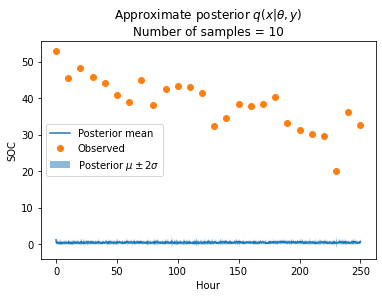

In [14]:
plot_post(x, obs_model_CON_noCO2, 0, num_samples=10)

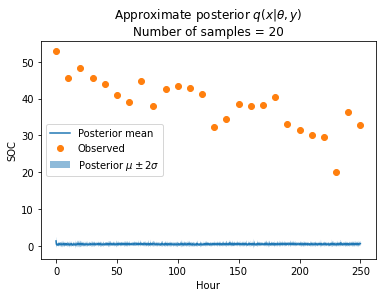

In [15]:
plot_post(x20, obs_model_CON_noCO2, 0, num_samples=20)

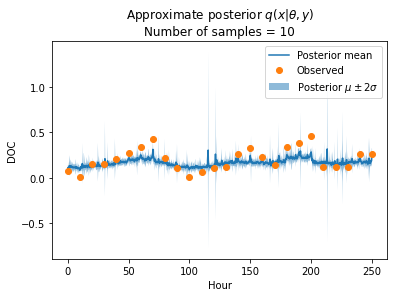

In [16]:
plot_post(x, obs_model_CON_noCO2, 1, num_samples=10)

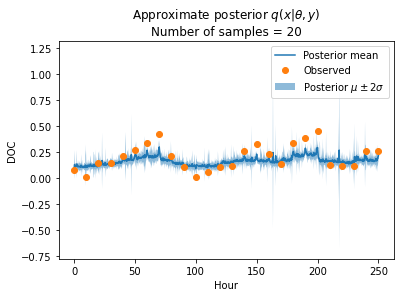

In [17]:
plot_post(x20, obs_model_CON_noCO2, 1, num_samples=20)

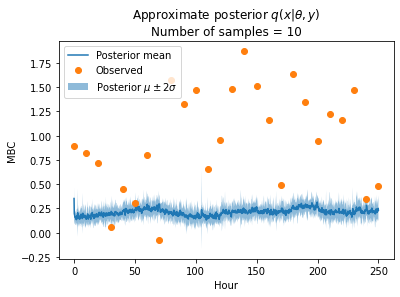

In [18]:
plot_post(x, obs_model_CON_noCO2, 2, num_samples=10)

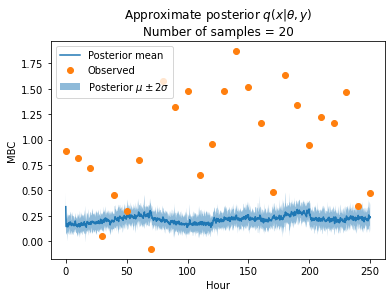

In [19]:
plot_post(x20, obs_model_CON_noCO2, 2, num_samples=20)

In [20]:
def plot_elbo(elbo_hist, xmin=0, ymax=None, yscale='linear', title=None):
    iters = torch.arange(xmin + 1, len(elbo_hist) + 1)
    plt.plot(iters, elbo_hist[xmin:])
    plt.ylim((None, ymax))
    plt.yscale(yscale)
    plt.ylabel('- ELBO')
    plt.xlabel('Iteration')
    plt.title(title)

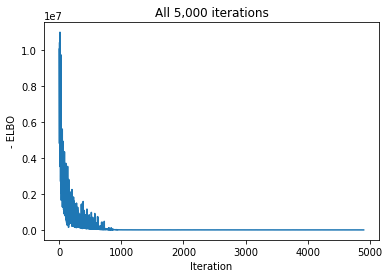

In [21]:
plot_elbo(elbo_hist, title='All 5,000 iterations')

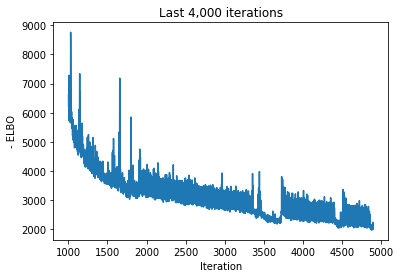

In [22]:
plot_elbo(elbo_hist, xmin=1000, title='Last 4,000 iterations')

In [ ]:
plot_elbo(elbo_hist, yscale='symlog')

In [ ]:
print(net)

In [ ]:
net(2)

In [ ]:
C0

In [ ]:
obs_model_CON_noCO2.times

In [ ]:
obs_model_CON_noCO2.mu.shape

In [ ]:
obs_model_CON_noCO2.scale.shape

In [ ]:
inputs = torch.arange(10, dtype=torch.float).reshape((1, 10))
means = inputs.mean(0)

In [ ]:
(inputs - means).pow(2).mean(0)

In [ ]:
torch.sqrt(torch.tensor(1e-6))